# Side Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time
import re
import scipy.stats as stats
from tqdm import tqdm

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

from joblib import Parallel, delayed

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#mne.viz.set_3d_backend('pyvistaqt')

In [2]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']
clusters_chs['All'] = channels

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal', 'All':'All'}

chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

ch_pairs = []
for l,r in zip(chan_left_all, chan_right_all):
    ch_pairs.append(f'{l}-{r}')
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = '/Users/nick/Documents/PhD/3DMOT_BCI/src/'
directory_data = '/Users/nick/Documents/PhD/3DMOT_BCI/data - raw/'
directory_preproc = '/Users/nick/Documents/PhD/3DMOT_BCI/data - preprocessed/'

# 0. Saving all data in .pkl files for faster load and analysis.

In [18]:
#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
sep = '/'

#filepath = directory_data + 'W10F2.bdf'#'T25F1.bdf' #'F12F2.bdf' #'T25F1.bdf'
for filepath in glob.iglob(directory_data + '*.bdf'):
    filename = filepath[filepath.rfind(sep)+1:]
        
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True, verbose=False)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M1_B3.bdf', preload=True, verbose=False)
            raw3 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M1_B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M2_B3.bdf', preload=True, verbose=False)
            raw3 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'M8M2_B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'T9F2_B3-B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True, verbose=False)
            raw2 = read_raw_bdf(filepath[:filepath.rfind(sep)+1] + 'T9M1_B3-B4.bdf', preload=True, verbose=False)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'        
    
    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Sampling Frequency
    raw.resample(512)
    sfreq = raw.info['sfreq']

    # Events 
    events = find_events(raw)

    # Load Behav Data.
    df_behav = pd.read_csv(directory_data + filename[:filename.rfind('.')] + '.csv', sep=',')

    # Rework Events based on Behav Data. (to add Side and SetSize information)
    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            #if (nb_trials + 1) % 10 == 0:
                #print('Check Synch!')

    # Working with modified events from now on.
    events = new_events

    # Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
    print('==================================================')
    print('Removing Events ID not in EEG File...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events)[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================') 

    # Epoch and use Bipolar Channels
    epochs = Epochs(raw, events, event_id=cur_event_id, tmin=-1, tmax=14, picks='eeg', baseline=(-0.4, 0), preload=True, event_repeated='merge', on_missing='warn')
    epochs = mne.set_bipolar_reference(epochs, anode=chan_left_all, cathode=chan_right_all, verbose=False)
    epochs = epochs.pick_channels(ch_pairs)
    
    # Save epochs
    with open(directory_preproc + sep + 'rawBipolar' + sep + filename[:filename.rfind('.')] + '.pkl', 'wb') as f:
        pickle.dump(epochs, f)
    

Processing: F26F2.bdf...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
237 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Event: 3/right/good (311), not present.
Not setting metadata
Not setting metadata
42 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 42 events and 7681 original time points ...
0 bad epochs dropped
Processing: F5M1.bdf...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
258 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132)

Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 7681 original time points ...
0 bad epochs dropped
Processing: T18M1.bdf...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 7681 original time points ...
0 bad epochs dropped
Pr

In [21]:
epochs_dict_all = dict()

for filepath in glob.iglob(directory_preproc + sep + 'rawBipolar' + sep + '*.pkl'):
    filename = filepath[filepath.rfind(sep)+1:]
    
    if filename == 'all_participants.pkl':
        continue

    print('Adding: ' + filename + '...')
    
    with open(filepath, 'rb') as f:
        epochs_dict_all[filename] = pickle.load(f)
        
print('Saving in all_participants.pkl!')
with open(directory_preproc + 'rawBipolar' + sep + 'all_participants.pkl', 'wb') as f:
    pickle.dump(epochs_dict_all, f)

Adding: T16F2.pkl...
Adding: F26F2.pkl...
Adding: F5M1.pkl...
Adding: S21F1.pkl...
Adding: M8M2.pkl...
Adding: F19M1.pkl...
Adding: M8M1.pkl...
Adding: W10F2.pkl...
Adding: S20M1.pkl...
Adding: M22F2.pkl...
Adding: W17M2.pkl...
Adding: T11F1.pkl...
Adding: T18M1.pkl...
Adding: F12F2.pkl...
Adding: T23F1.pkl...
Adding: T23F2.pkl...
Adding: F12M1.pkl...
Adding: T25F1.pkl...
Adding: T18F2.pkl...
Adding: T9F2.pkl...
Saving in all_participants.pkl!


In [4]:
print('Loading all_participants.pkl!')
with open(directory_preproc + 'rawBipolar' + '/' + 'all_participants.pkl', 'rb') as f:
    epochs_dict_all = pickle.load(f)

Loading all_participants.pkl!


# 1. All Participants

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


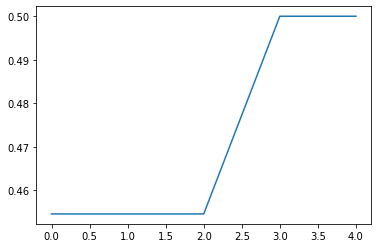

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


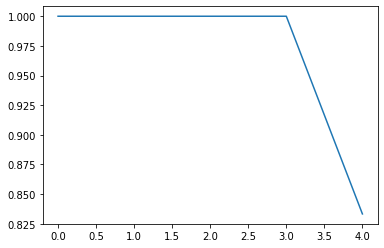

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


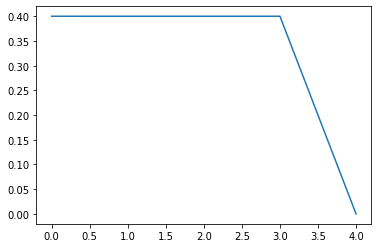

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


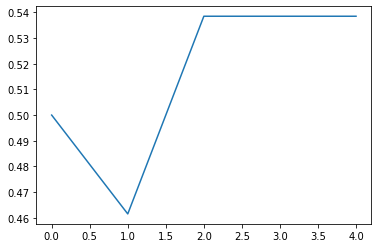

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


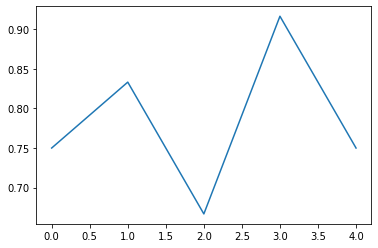

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


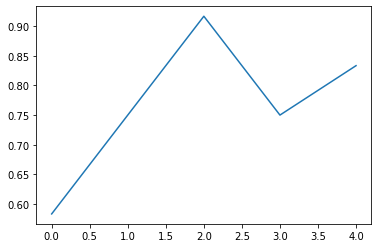

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


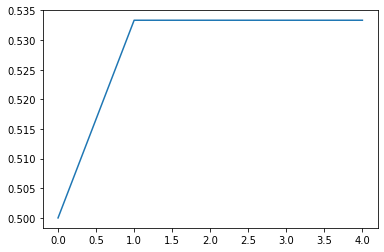

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


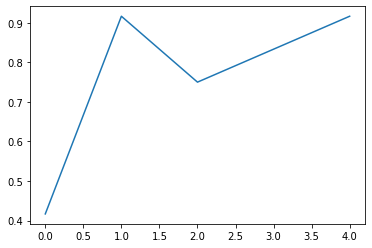

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


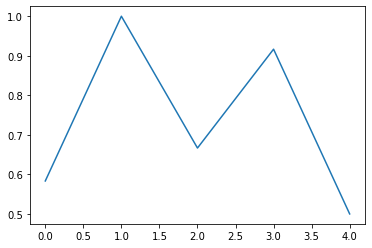

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


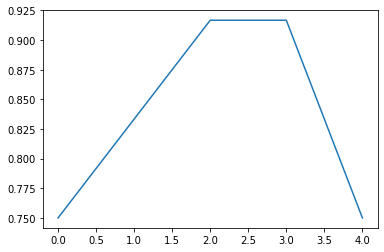

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


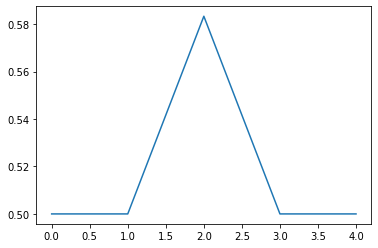

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


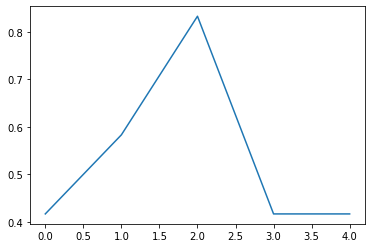

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


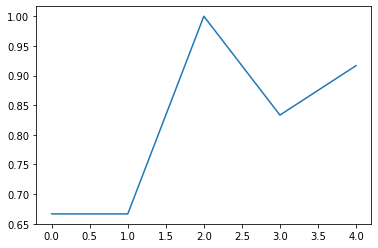

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


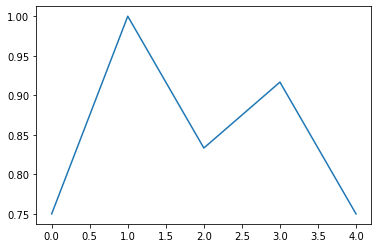

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


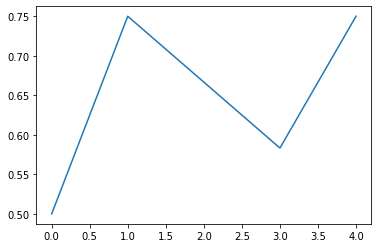

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


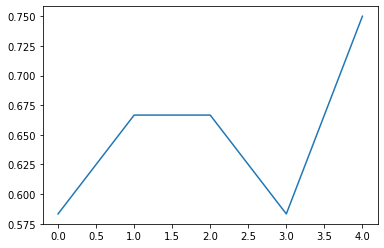

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


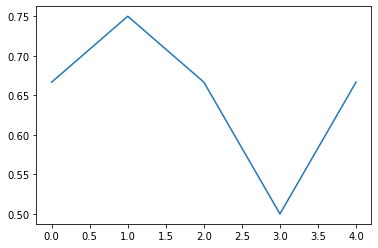

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


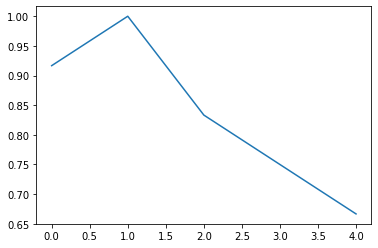

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


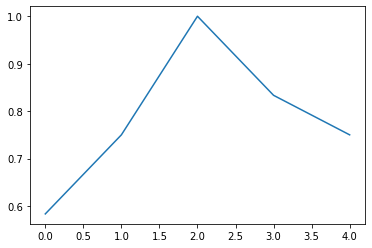

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


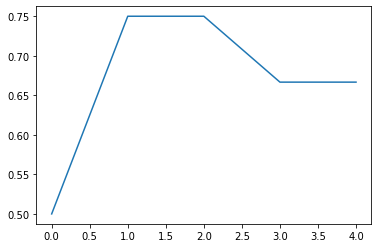

T16F2.pkl: 0.47
F26F2.pkl: 0.97
F5M1.pkl: 0.32
S21F1.pkl: 0.52
M8M2.pkl: 0.78
F19M1.pkl: 0.77
M8M1.pkl: 0.53
W10F2.pkl: 0.77
S20M1.pkl: 0.73
M22F2.pkl: 0.83
W17M2.pkl: 0.52
T11F1.pkl: 0.53
T18M1.pkl: 0.82
F12F2.pkl: 0.85
T23F1.pkl: 0.65
T23F2.pkl: 0.65
F12M1.pkl: 0.65
T25F1.pkl: 0.83
T18F2.pkl: 0.78
T9F2.pkl: 0.67
Grand Average: 68.17
Min: 32.00
Max: 96.67
std: 15.66


In [6]:
scores_dict = dict()

# Machine Learning Pipeline
#clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
clf = make_pipeline(LogisticRegression(solver='lbfgs'))

for participant in epochs_dict_all.keys():
    epochs_temp = epochs_dict_all[participant].copy().crop(tmin=0, tmax=14)
    times = epochs_temp.times

    rf1 = np.mean(epochs_temp['left'].pick_channels(['O1-O2']).get_data(picks='eeg').squeeze()[:, (times >= 0.4) & (times <= 0.6)], 1)
    rf2 = np.mean(epochs_temp['left'].pick_channels(['PO3-PO4']).get_data(picks='eeg').squeeze()[:, (times >= 0.4) & (times <= 0.6)], 1)
    rf4 = np.mean(epochs_temp['left'].pick_channels(['FT7-FT8']).get_data(picks='eeg').squeeze()[:, (times >= 11.5) & (times <= 12.5)], 1)
    rf5 = np.mean(epochs_temp['left'].pick_channels(['F5-F6']).get_data(picks='eeg').squeeze()[:, (times >= 11.5) & (times <= 12.5)], 1)
    left_features = np.dstack((rf1, rf2, rf4, rf5)).squeeze()

    rf1 = np.mean(epochs_temp['right'].pick_channels(['O1-O2']).get_data(picks='eeg').squeeze()[:, (times >= 0.4) & (times <= 0.6)], 1)
    rf2 = np.mean(epochs_temp['right'].pick_channels(['PO3-PO4']).get_data(picks='eeg').squeeze()[:, (times >= 0.4) & (times <= 0.6)], 1)
    rf4 = np.mean(epochs_temp['right'].pick_channels(['FT7-FT8']).get_data(picks='eeg').squeeze()[:, (times >= 11.5) & (times <= 12.5)], 1)
    rf5 = np.mean(epochs_temp['right'].pick_channels(['F5-F6']).get_data(picks='eeg').squeeze()[:, (times >= 11.5) & (times <= 12.5)], 1)
    right_features = np.dstack((rf1, rf2, rf4, rf5)).squeeze()

    X = np.vstack((left_features, right_features)) #.reshape(-1, 1)
    y = np.hstack((np.zeros(left_features.shape[0]), np.ones(right_features.shape[0]))) #.reshape(-1, 1)

    scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=5)
    scores_dict[participant] = scores

    plt.plot(scores)
    plt.show()

scores_subjs = []    
for participant in scores_dict.keys():
    avg = np.mean(scores_dict[participant], 0)
    if avg > 0.75:
        print("\x1b[31m" + '{}: {:.2f}'.format(participant, avg))
    else:
        print("\x1b[0m" + '{}: {:.2f}'.format(participant, avg))
    scores_subjs.append(avg)
    
scores_subjs = np.array(scores_subjs)
print('Grand Average: {:.2f}'.format(scores_subjs.mean(0) * 100))
print('Min: {:.2f}'.format(scores_subjs.min(0) * 100))
print('Max: {:.2f}'.format(scores_subjs.max(0) * 100))
print('std: {:.2f}'.format(scores_subjs.std(0) * 100))